In [1]:
import os

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("ggplot")

## Constants

In [2]:
IMAGE_DIR = "./data_gen/data/img/"

## Helpers

In [3]:
def imshow(img, ax=None, vmin=None, vmax=None, figsize=(7, 7), external=False, title=""):
    if external:
        cv.imshow("imshow", img)
        
        while 1:
            if cv.waitKey(0) & 0xFF == ord("q"):
                break
        
        cv.destroyAllWindows()
        return
    
    gray = False

    if len(img.shape) == 2:
        gray = True
    if img.shape == 3 and img.shape[-1] == 1:
        gray = True

    # trying to remove as much as possible
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(title)
    ax.autoscale(tight=True)
    
    if gray:
        ax.imshow(img, cmap="gray", vmin=vmin, vmax=vmax)
    else:
        ax.imshow(img[:, :, ::-1], vmin=vmin, vmax=vmax)

In [4]:
IMAGES = list(map(lambda x: cv.imread(os.path.join(IMAGE_DIR, x), 0), os.listdir(IMAGE_DIR)[:10]))

### Test pipeline

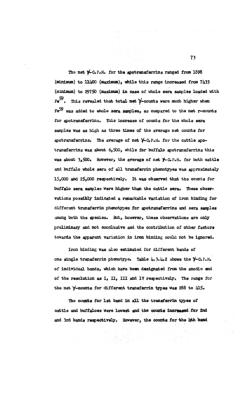

In [5]:
img = IMAGES[1]
imshow(img)

In [6]:
def preprocess_img(img):
    img = img.copy()

    # we don't need color
    if len(img.shape) == 3:
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # bilateral >> gaussian
    img = cv.bilateralFilter(img, 15, 100, 100)
    
    # binarize. since we are using printed images for now, normal thresh works
    # later we can change it to adaptive thresh
    _, img = cv.threshold(img, 127, 255, cv.THRESH_BINARY_INV)
    
    return img

In [7]:
def get_text_mask(img):
    img = img.copy()
    kernel = np.ones((5, 5))
    
    # remove small noises
    img = cv.erode(img, kernel)
    
    # dilate multiple times to expand text
    img = cv.dilate(img, kernel, iterations=15)
    
    return img

In [8]:
def mark_roi(img, mask_img):
    rect = cv.minAreaRect(cv.findNonZero(mask_img))
    box = np.int0(cv.boxPoints(rect))
    return cv.drawContours(img.copy(), [box], 0, (0,), 3)

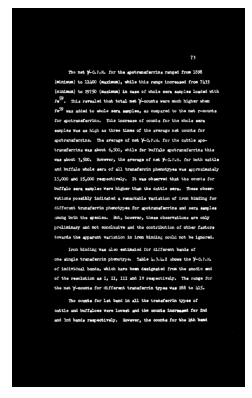

In [9]:
p_img = preprocess_img(img)
imshow(p_img)

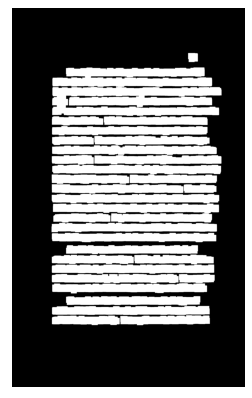

In [10]:
m_img = get_text_mask(p_img)
imshow(m_img)

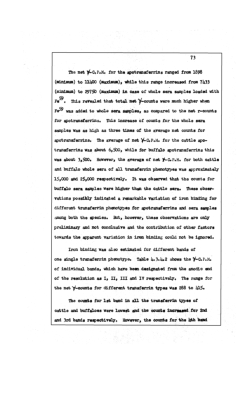

In [11]:
imshow(mark_roi(img, m_img))

## Translation invariant

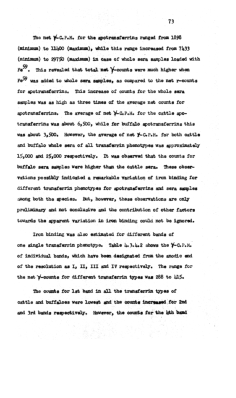

In [12]:
im_translate = img[400:, 400:]
imshow(im_translate)

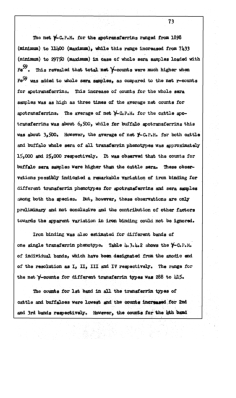

In [13]:
imshow(mark_roi(im_translate, get_text_mask(preprocess_img(im_translate))))

## Rotation invariant

In [14]:
def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """

    height, width = mat.shape[:2] # image shape has 3 dimensions
    image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

    rotation_mat = cv.getRotationMatrix2D(image_center, angle, 1.)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv.warpAffine(mat, rotation_mat, (bound_w, bound_h), borderMode=cv.BORDER_CONSTANT, borderValue=(255, 255, 255))
    return rotated_mat

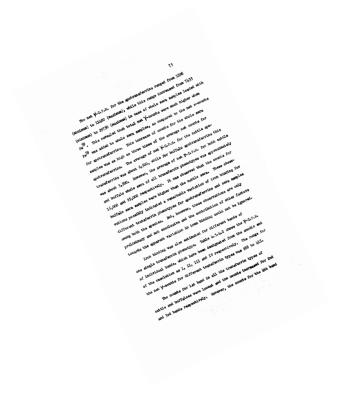

In [15]:
im_rot = rotate_image(img, 25)
imshow(im_rot)

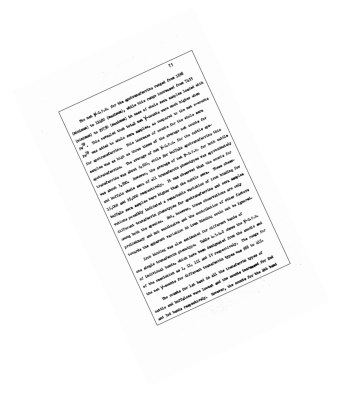

In [16]:
imshow(mark_roi(im_rot, get_text_mask(preprocess_img(im_rot))))

## Scaling invariant

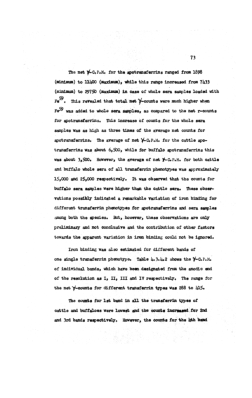

In [17]:
im_sc = cv.resize(img, (0, 0), fx=1.25, fy=1.25)
imshow(im_sc)

In [18]:
img.shape, im_sc.shape

((4044, 2492), (5055, 3115))

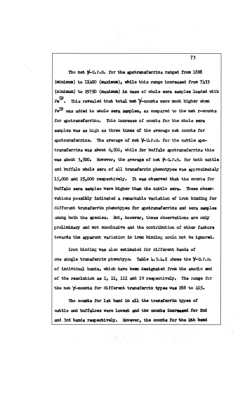

In [19]:
imshow(mark_roi(im_sc, get_text_mask(preprocess_img(im_sc))))

## Why not all?

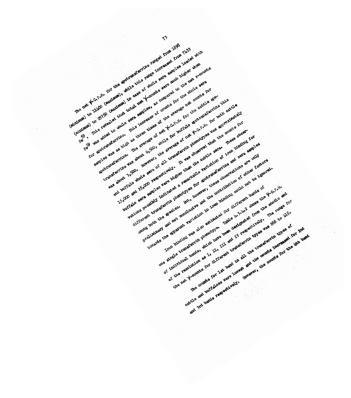

In [20]:
im_all = rotate_image(im_sc, 33)[500:, 200:-400]
imshow(im_all)

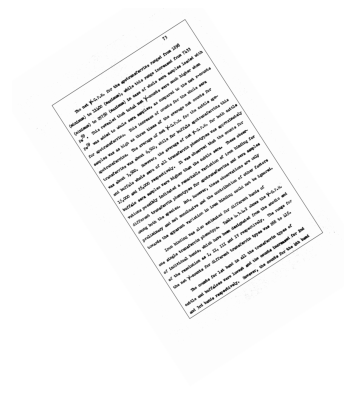

In [21]:
imshow(mark_roi(im_all, get_text_mask(preprocess_img(im_all))))